In [11]:
import pandas as pd
import numpy as np
import json
import seaborn as sns
import string
import warnings
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from scipy import sparse
import sys
import dill
import statsmodels.api as sm
from scipy.stats import chisquare

#dill.load_session("1or5.pk1")
np.set_printoptions(threshold=sys.maxsize)
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 50000)
print("done")

done


## Data filtering and loading and summary statistics

In [2]:
def parse(path):
  g = f = open(path, "r")
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df = getDF('Prime_Pantry.json')
df["time"] = pd.to_datetime(df["unixReviewTime"], unit='ms')
df['time'] = df['time'].dt.floor('Min')
filtered_df = df[["overall", "verified", "reviewerID","asin", "reviewText"]]
filtered_df["review_length"] = filtered_df['reviewText'].apply(lambda x: len(x) 
                                                               if type(x)== str else 0)
filtered_df['reviewText'] = filtered_df['reviewText'].fillna("")
filtered_df['reviewText'] = filtered_df['reviewText'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)).lower())
#filtered_df = filtered_df.loc[filtered_df.overall.isin([1,5])] 

filtered_df.head()

,overall,verified,reviewerID,asin,reviewText,review_length
0,5.0,True,A1NKJW0TNRVS7O,B0000DIWNZ,good clinging,13
1,4.0,True,A2L6X37E8TFTCC,B0000DIWNZ,fantastic buy and a good plastic wrap even th...,243
2,4.0,True,A2WPR4W6V48121,B0000DIWNZ,ok,2
3,3.0,False,A27EE7X7L29UMU,B0000DIWNZ,saran cling plus is kind of like most of the c...,1692
4,4.0,True,A1OWT4YZGB5GV9,B0000DIWNZ,this is my go to plastic wrap so there isnt mu...,585


#### Ratings distribution

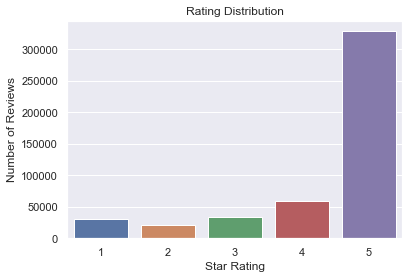

In [3]:
d = filtered_df['overall'].value_counts().reindex([1,2,3,4,5])
d = pd.DataFrame(d)
d.reset_index(inplace = True)
d.columns = ["Star Rating", "Number of Reviews"]
sns.set_theme(style="darkgrid")
ax = sns.barplot(x="Star Rating", y="Number of Reviews", data=d).set(title = "Rating Distribution")

#### Ratio of 5 stars and Chi square

In [12]:
a = filtered_df['overall'].value_counts().reindex([1,2,3,4,5])
print(a[5]/a.sum())
chisquare(a)

0.6964657537732128


Power_divergenceResult(statistic=735237.504620304, pvalue=0.0)

#### Box and whisker: Review length per star ratings

133.17044235328044


overall
1.0    187.780006
2.0    182.533713
3.0    160.708906
4.0    151.693191
5.0    118.918767
Name: review_length, dtype: float64

[Text(0.5, 1.0, 'Review Length for Each Star Rating')]

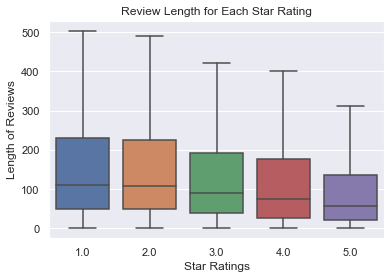

In [18]:
a = filtered_df[["overall", "review_length"]]
a.columns = ["Star Ratings", "Length of Reviews"]
print(a["Length of Reviews"].mean())
d = filtered_df.groupby("overall")
display(d["review_length"].mean())
sns.boxplot(x = "Star Ratings", y = "Length of Reviews", data = a, showfliers = False).set(
    title = "Review Length for Each Star Rating")

#### Multinomial Regression Test

In [10]:
X = filtered_df["review_length"]
Y = filtered_df["overall"]
ratings_mnr = sm.MNLogit(Y, X)
results = ratings_mnr.fit(method='lbfgs')
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:                overall   No. Observations:               471614
Model:                        MNLogit   Df Residuals:                   471610
Method:                           MLE   Df Model:                            0
Date:                Tue, 28 Dec 2021   Pseudo R-squ.:                 -0.5910
Time:                        16:18:50   Log-Likelihood:            -7.5903e+05
converged:                      False   LL-Null:                   -4.7708e+05
Covariance Type:            nonrobust   LLR p-value:                       nan
=================================================================================
    overall=2       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
review_length          0   1.85e-05          0      1.000   -3.62e-05    3.62e-05
---------------------------------------------------------------------------------
    overall=3       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
review_length          0   1.85e-05          0      1.000   -3.62e-05    3.62e-05
---------------------------------------------------------------------------------
    overall=4       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
review_length          0   1.85e-05          0      1.000   -3.62e-05    3.62e-05
---------------------------------------------------------------------------------
    overall=5       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
review_length          0   1.85e-05          0      1.000   -3.62e-05    3.62e-05
=================================================================================
"""

Summary statistics for Products

In [21]:
print("The most used product:", len(filtered_df.loc[filtered_df['asin'] == 'B00I3MVY9I']))
print("Average number of uses:", len(filtered_df['asin'])/len(filtered_df['asin'].unique()))
c = filtered_df.groupby('asin')
col1 = c['overall'].count()
col2 = c['overall'].mean()
cf = pd.DataFrame([col1,col2]).T
cf.columns = ["num", "rating"]
m = cf.loc[cf['num']>=100, "rating"].max()
am = cf.loc[cf['num']>=100, "rating"].argmax()
print(filtered_df.loc[filtered_df['asin'] == 'B014DBBP0U'][0:5])

The most used product: 6537
Average number of uses: 43.611429628259664
        overall  verified      reviewerID        asin  \
324987      4.0      True  A3A63SLZ5BLNPZ  B014DBBP0U   
324988      5.0      True  A12JAL2HLYAYS9  B014DBBP0U   
324989      5.0      True   AR4R0I0ISSUJ5  B014DBBP0U   
324990      5.0      True  A38TLO7ZFGOWM5  B014DBBP0U   
324991      5.0      True  A108NSP1VH323U  B014DBBP0U   

                                               reviewText  review_length  
324987   product as described and delivered when promised             49  
324988                                             thanks              6  
324989  my dogs love these and they really help with d...             59  
324990                                    my dog loves it             15  
324991                                          love them              9  


Summary stats for reviews/reviewers

In [7]:
len(filtered_df['reviewerID'])/len(filtered_df['reviewerID'].unique())
fg = filtered_df.groupby('reviewerID')
fg.count().max()
lonr = filtered_df['review_length'].max()
lonra = filtered_df['review_length'].argmax()
filtered_df.iloc[lonra]

overall                                                        5.0
verified                                                     False
reviewerID                                          A2XKJ1KX6XUHYP
asin                                                    B00MHTGEHA
reviewText       general no these will not make you high mental...
review_length                                                10176
Name: 145905, dtype: object

### Count Vectorization

In [26]:
filtered_df = filtered_df.loc[filtered_df.overall.isin([1,5])] 

display(filtered_df.head())
sample = filtered_df
data = sample["reviewText"]
labels = sample["overall"]
CV = CountVectorizer(ngram_range=(1,1), stop_words='english', max_features= 10000)
revList = data.tolist()
countData = CV.fit_transform(revList)
column_names = CV.get_feature_names()
display(countData)

,overall,verified,reviewerID,asin,reviewText,review_length
0,5.0,True,A1NKJW0TNRVS7O,B0000DIWNZ,good clinging,13
5,5.0,True,A1GN2ADKF1IE7K,B0000DIWNZ,works very well clings to my glass baking dish...,57
6,1.0,False,A3SJKIHSPA2MDZ,B0000DIWNZ,i find the 200 foot roll of saran cling plus n...,1047
7,5.0,True,A2YXHRKCDBEJKX,B0000DIWNZ,i like saran wrap better than glad for some re...,226
8,5.0,True,A4NK3T8BCMJQ8,B0000DIWNZ,an excellent product with great sticking power...,235


<359082x10000 sparse matrix of type '<class 'numpy.int64'>'
	with 3433925 stored elements in Compressed Sparse Row format>

In [27]:
cv_for_demo = pd.DataFrame(countData[0:10].toarray())
cv_for_demo.columns = column_names
print(cv_for_demo.head())
#print(type(countData[0:10].toarray()))
cont_dat = countData.sum(axis = 0)
a = np.argsort(cont_dat)[0:9]
print(a)

   05  0g  0mg  10  100  1000  10000  1000mg  1010  1012  ...  ziplock  \
0   0   0    0   0    0     0      0       0     0     0  ...        0   
1   0   0    0   0    0     0      0       0     0     0  ...        0   
2   0   0    0   0    0     0      0       0     0     0  ...        0   
3   0   0    0   0    0     0      0       0     0     0  ...        0   
4   0   0    0   0    0     0      0       0     0     0  ...        0   

   zipper  zits  zombie  zone  zoo  zoom  zucchini  zukes  zyrtec  
0       0     0       0     0    0     0         0      0       0  
1       0     0       0     0    0     0         0      0       0  
2       0     0       0     0    0     0         0      0       0  
3       0     0       0     0    0     0         0      0       0  
4       0     0       0     0    0     0         0      0       0  

[5 rows x 10000 columns]
[[ 337 9492 5035 2515  358 9503  976 2198 4133 3477 4176 5079 2903 5089
  6860 9549 1831 6253 8425 6256 2887 9527 9488  3

In [28]:
cont_dat = countData.sum(axis = 0)
cont_dat = np.asarray(cont_dat)
cont_dat = np.reshape(cont_dat, -1)
a = np.argsort(cont_dat)
ten_big = a[0:]
ten_size = cont_dat[ten_big]
con = np.asarray(column_names)
ten_names = con[ten_big]
daftt = pd.DataFrame([ten_names, ten_size]).T
daftt.columns = ['word', 'count']
daftt.head(10)
print(cont_dat.mean())

379.0699


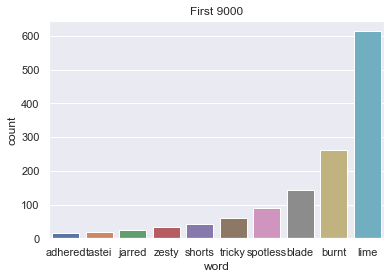

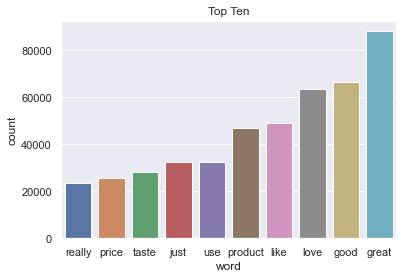

In [29]:
import matplotlib.pyplot as plt
sns.set_theme(style="darkgrid")
ax = sns.barplot(x="word", y="count", data=daftt.iloc[[0,1000,2000,3000,4000,5000,6000,7000,8000,9000]]).set(title = "First 9000")
plt.show()
sns.set_theme(style="darkgrid")
ax = sns.barplot(x="word", y="count", data=daftt[-10:]).set(title = "Top Ten")

In [30]:
train_cv, test_cv, train_label, test_label = train_test_split(countData, labels, test_size = 0.2, random_state=42) 
print("hello")

hello


# Accuracy

In [13]:
lambda_coeff = np.logspace(-5, 5, num=11)
model_score = {}

print("starting")
train_cv = sparse.csr_matrix(train_cv)
for i in lambda_coeff:
    
    lr = LogisticRegression(penalty='l1', solver='liblinear', C=i, random_state=42)
    model_score[i] = cross_val_score(lr, train_cv, train_label, cv = 5).mean()
    print(i)

eval_mat = pd.DataFrame.from_dict(model_score, orient="index")
eval_mat

starting
hi
1e-05
0.0001
0.001
0.01
0.1
1.0
10.0
100.0
1000.0
10000.0
100000.0


,0
0.00001,0.085009
0.00010,0.914991
0.00100,0.914977
0.01000,0.934402
0.10000,0.952758
1.00000,0.959887
10.00000,0.957262
100.00000,0.954784
1000.00000,0.954307
10000.00000,0.954123


# ROC_AUC_Score

In [14]:
lambda_coeff = np.logspace(-3, 3, num=25)

model_score_f1_micro = {}
number_of_words = []
supports = []

train_cv = sparse.csr_matrix(train_cv)

for i in lambda_coeff:
    lr = LogisticRegression(penalty='l1', solver='liblinear', C=i, random_state=42)
    model_score_f1_micro[i] = cross_val_score(lr, train_cv, train_label, cv = 5, scoring="roc_auc").mean()
    sel = SelectFromModel(estimator= lr).fit(train_cv, train_label)
    a = sel.get_support()
    number_of_words.append(len(a))
    supports.append(a)
    print(i)

eval_mat_f1_score = pd.DataFrame.from_dict(model_score_f1_micro, orient="index")
eval_mat_f1_score

0.001
0.0017782794100389228
0.0031622776601683794
0.005623413251903491
0.01
0.01778279410038923
0.03162277660168379
0.05623413251903491
0.1
0.1778279410038923
0.31622776601683794
0.5623413251903491
1.0
1.7782794100389228
3.1622776601683795
5.623413251903491
10.0
17.78279410038923
31.622776601683793
56.23413251903491
100.0
177.82794100389228
316.22776601683796
562.341325190349
1000.0


,0
0.001000,0.753506
0.001778,0.825220
0.003162,0.870220
0.005623,0.897119
0.010000,0.915559
0.017783,0.929816
0.031623,0.939525
0.056234,0.946168
0.100000,0.951045
0.177828,0.954692


Getting word counts for each model

In [15]:
count = []
for a in supports:
    count.append(0)
    for i in range(len(a)):
        if a[i]==True:
            count[-1] +=1
print(count))

[15, 31, 59, 90, 179, 287, 444, 687, 1084, 1650, 2440, 3541, 4909, 6286, 7451, 8229, 8794, 9152, 9422, 9593, 9724, 9804, 9862, 9894, 9923]


Creating a pandas DF that contains all of our desired results

In [54]:
lambdas = []
for key in model_score_f1_micro:
    lambdas.append(key)
counts = count[::-1]
log_lambdas = np.log(lambdas)/np.log(10)
scores = list(model_score_f1_micro.values())[::-1]
eva = pd.DataFrame([lambdas, log_lambdas, counts, scores]).T 
eva.columns = ["Lambda","log(Lambda)","count","score"]
eva

,Lambda,log(Lambda),count,score
0,0.001000,-3.00,9923.0,0.922869
1,0.001778,-2.75,9894.0,0.924035
2,0.003162,-2.50,9862.0,0.925314
3,0.005623,-2.25,9804.0,0.926808
4,0.010000,-2.00,9724.0,0.928714
5,0.017783,-1.75,9593.0,0.930961
6,0.031623,-1.50,9422.0,0.933670
7,0.056234,-1.25,9152.0,0.937073
8,0.100000,-1.00,8794.0,0.941086
9,0.177828,-0.75,8229.0,0.945628


Plottin the results for both the ideal and limited model

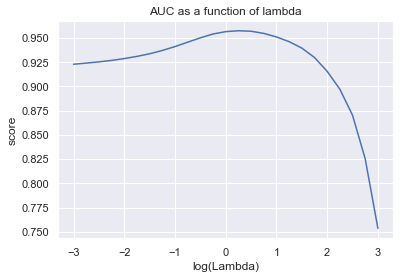

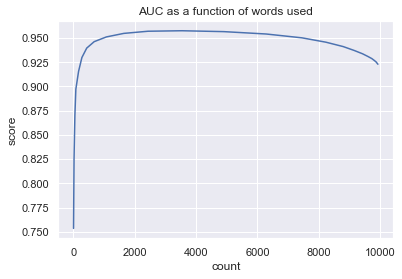

In [42]:
sns.set_theme(style="darkgrid")
ax = sns.lineplot(x="log(Lambda)", y="score", data = eva).set(title = "AUC as a function of lambda")
plt.show()
sns.set_theme(style="darkgrid")
ax = sns.lineplot(x="count", y="score", data = eva).set(title = "AUC as a function of words used")

Training a model using the limited lambda and getting the word list

In [44]:
lr = LogisticRegression(penalty='l1', solver='liblinear', C=1/178, random_state=42)
lr.fit(train_cv, train_label)
sel = SelectFromModel(estimator= lr).fit(train_cv, train_label)
a = sel.get_support()
lr_co = lr.coef_
kept_words = {}
for i in range(len(a)):
    row = lr_co[0,i]
    if a[i]==True:
        kept_words[column_names[i]] = row

In [45]:
kept_words

{'amazing': 0.8107835975857448,
 'arrived': -0.18415858099488894,
 'away': -0.5437026121903444,
 'awesome': 0.7240443248114884,
 'awful': -1.9393420663538723,
 'bad': -0.9263469509107791,
 'bag': -0.13228754957550767,
 'best': 1.5507451207481728,
 'better': 0.11866399733525007,
 'bought': -0.26322001915655596,
 'box': -0.6681900406232297,
 'broken': -0.8523673560151332,
 'buy': -0.30904621751664113,
 'cans': -0.4479799521224167,
 'clean': 0.14127339942826084,
 'crushed': -0.22890537692886792,
 'date': -0.49203439575117164,
 'day': 0.10613690771397673,
 'definitely': 0.15968934312741132,
 'delicious': 1.4938655941332062,
 'described': 0.11857174264768391,
 'did': -0.7015694682444444,
 'didnt': -0.7267468035156323,
 'disappointed': -1.8783393478325008,
 'disgusting': -1.3084345284602032,
 'doesnt': -0.054606319167268894,
 'dont': -0.22982344007222608,
 'easy': 0.7363669434913226,
 'excellent': 1.2425509460819502,
 'expected': 0.04139947340012492,
 'favorite': 1.3601698021764062,
 'flavor

In [100]:
eva_dump_path = "eva.pkl"
with open('eva.pkl', 'wb') as file:
    dill.dump(eva, file)
print("done")

done


In [96]:
dill.detect.baditems(eva.any(), exact=False, safe=False)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

Confusion matrices for both models

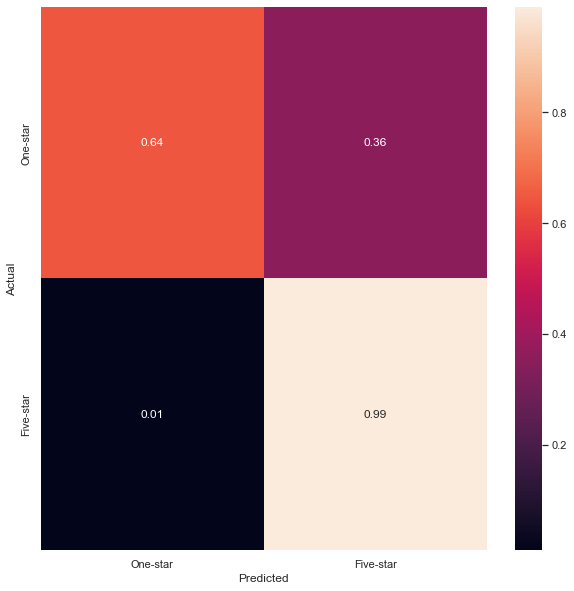

In [37]:
from sklearn.metrics import confusion_matrix

lr = LogisticRegression(penalty='l1', solver='liblinear', C=1/1.77, random_state=42)
lr.fit(train_cv, train_label)
y_pred = lr.predict(test_cv)
cm = confusion_matrix(test_label,y_pred)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=["One-star","Five-star"], yticklabels=["One-star","Five-star"])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

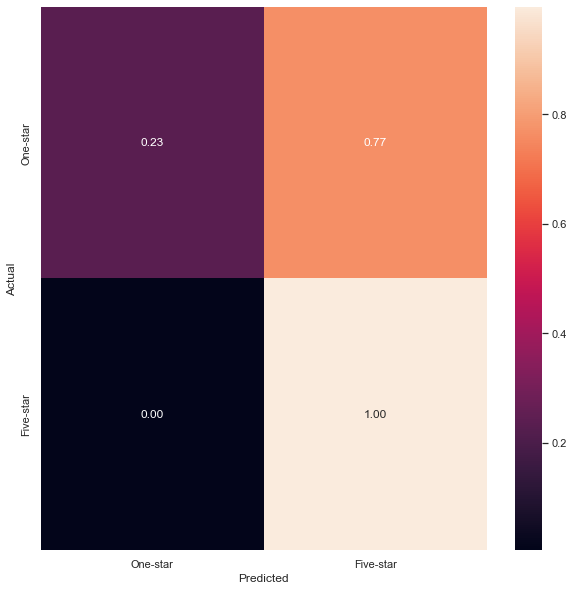

In [38]:
lr = LogisticRegression(penalty='l1', solver='liblinear', C=1/177, random_state=42)
lr.fit(train_cv, train_label)
y_pred = lr.predict(test_cv)
cm = confusion_matrix(test_label,y_pred)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=["One-star","Five-star"], yticklabels=["One-star","Five-star"])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)